# Efficient subset using Sentence Transformers

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns

import random
import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel, BertForSequenceClassification, BertModel
from transformers import AutoTokenizer, BertTokenizer
from transformers import AutoConfig

from torch.optim.lr_scheduler import StepLR
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, notebook

from sklearn.model_selection import train_test_split

In [89]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 55
seed_everything(SEED)

Device:  cuda


In [5]:
data_train_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')
data_test_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')
len(data_train_df), len(data_test_df)

(41157, 3798)

In [6]:
data_train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
data_train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

<Axes: xlabel='Sentiment', ylabel='count'>

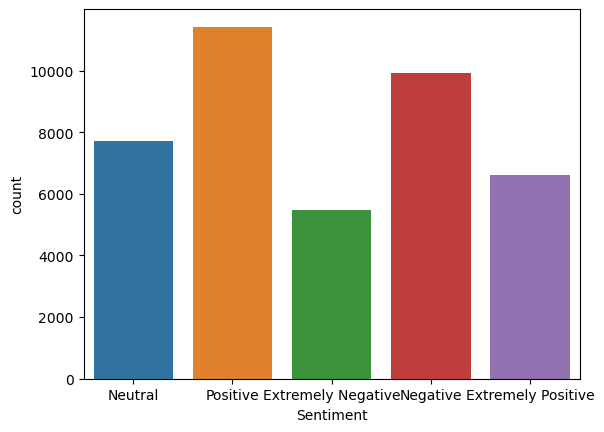

In [8]:
sns.countplot(data=data_train_df, x='Sentiment')

<Axes: xlabel='Sentiment', ylabel='count'>

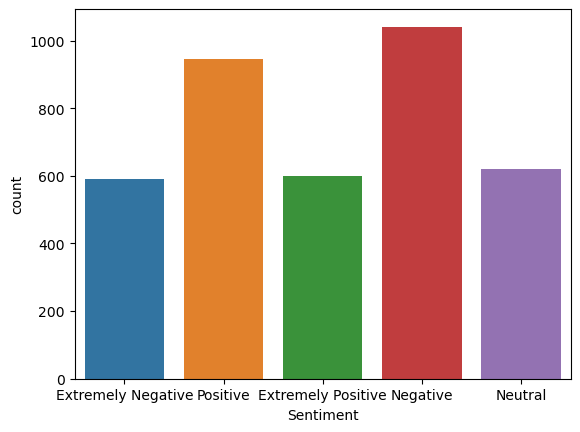

In [9]:
sns.countplot(data=data_test_df, x='Sentiment')

In [10]:
def combine_labels(label):
    if 'Positive' in label:
        return 'Positive'
    elif 'Negative' in label:
        return 'Negative'
    else:
        return label

In [11]:
data_train_df['Label'] = data_train_df['Sentiment'].apply(lambda x: combine_labels(x))
data_test_df['Label'] = data_test_df['Sentiment'].apply(lambda x: combine_labels(x))

In [12]:
data_train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative


In [13]:
data_test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Label
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,Neutral


Only working on positive/negative labels for experimentation purpose on binary classifcation

In [14]:
df = data_train_df[data_train_df['Label'] != 'Neutral'][['OriginalTweet', 'Label']]
test_df = data_test_df[data_test_df['Label'] != 'Neutral'][['OriginalTweet', 'Label']]
labels = {'Positive':0, 'Negative':1}
df['Label'] = df.Label.apply(lambda x: labels[x])
test_df['Label'] = test_df.Label.apply(lambda x: labels[x])

In [15]:
df.head()

,OriginalTweet,Label
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",1
5,As news of the regionÂs first confirmed COVID...,0


In [16]:
test_df.head()

,OriginalTweet,Label
0,TRENDING: New Yorkers encounter empty supermar...,1
1,When I couldn't find hand sanitizer at Fred Me...,0
2,Find out how you can protect yourself and love...,0
3,#Panic buying hits #NewYork City as anxious sh...,1
6,Voting in the age of #coronavirus = hand sanit...,0


In [17]:
len(df), len(test_df)

(33444, 3179)

In [18]:
cfg = {}
BERT = 'bert-base-uncased'
DISTIL_BERT = 'distilbert-base-uncased'
ROBERTA = 'roberta-base'
MODEL_PATH = DISTIL_BERT

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df.OriginalTweet, df.Label, test_size=0.15, random_state=SEED, stratify=df.Label)

In [20]:
len(X_train), len(X_val)

(28427, 5017)

In [21]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

<Axes: xlabel='Label', ylabel='count'>

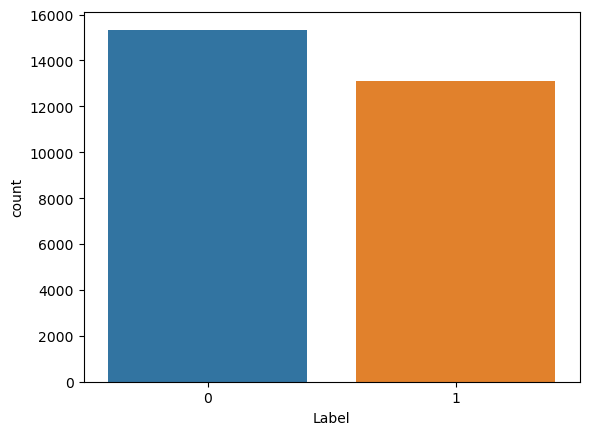

In [22]:
sns.countplot(data=train_df, x='Label')

<Axes: xlabel='Label', ylabel='count'>

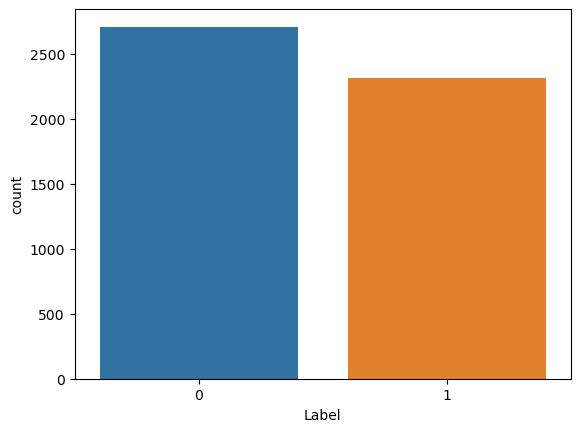

In [23]:
sns.countplot(data=val_df, x='Label')

In [24]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [139]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 5
cfg['learning_rate'] = 1e-05

In [26]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'OriginalTweet']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'Label']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [27]:
class TweetSentimentBERT(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(TweetSentimentBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name
        
        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == DISTIL_BERT:
            self.in_features = self.bert.transformer.layer[5].output_layer_norm.normalized_shape[0]
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        # self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == DISTIL_BERT:
            last_hidden_state = self.bert(input_ids,
                                          attention_mask=attention_mask,
                                          return_dict=False)
            first_token_tensor = last_hidden_state[0][:, 0]
            output = self.dense(first_token_tensor)
            output = self.activation(output)
            
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        # output = self.dropout(output)
        output = self.classifier(output)
        return output

In [28]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [29]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    
    print("Start training...\n")
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())
            
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 50 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [30]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [31]:
train_data = TweetDataset(train_df, tokenizer, cfg['max_length'])
val_data = TweetDataset(val_df, tokenizer, cfg['max_length'])
test_data = TweetDataset(test_df, tokenizer, cfg['max_length'])

In [32]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [33]:
# model = TweetSentimentBERT(MODEL_PATH)
# model.to(device)

In [34]:
# num_training_steps = cfg['epochs']*len(train_loader)
# num_warmup_steps = 0
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
# )

In [35]:
# train(model, loss_function, train_loader, val_loader, epochs=cfg['epochs'], evaluation=True)

In [36]:
# test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
# test_loss, test_accuracy

<Axes: xlabel='Label', ylabel='count'>

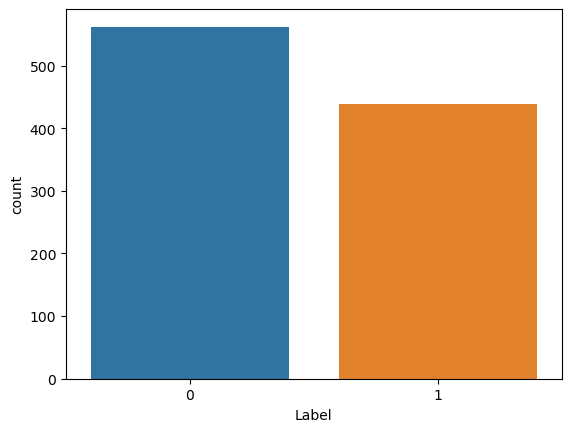

In [82]:
train_df_smpl = train_df.sample(1000).reset_index(drop=True)
sns.countplot(data=train_df_smpl, x='Label')

In [90]:
train_data_smpl = TweetDataset(train_df_smpl, tokenizer, cfg['max_length'])
train_loader_smpl = DataLoader(train_data_smpl, **train_params)

In [91]:
model_smpl = TweetSentimentBERT(MODEL_PATH)
model_smpl.to(device)
num_training_steps = cfg['epochs']*len(train_loader_smpl)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_smpl.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
train(model_smpl, loss_function, train_loader_smpl, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   31    |   0.647012   |     -      |     -     |   12.21  
----------------------------------------------------------------------
   1    |    -    |   0.647012   |  0.622169  |   63.80   |   33.37  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   31    |   0.496532   |     -      |     -     |   12.28  
----------------------------------------------------------------------
   2    |    -    |   0.496532   |  0.526584  |   74.35   |   33.45  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

In [93]:
test_loss, test_accuracy = evaluate(model_smpl, loss_function, test_loader)
test_loss, test_accuracy

(0.7460896022355736, 75.73949291914117)

In [39]:
!pip install faiss-cpu
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 64.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=16e7ea11c85f9088b73c1028f35631c5a3cd1b6f41ba6d7983583d39a9eded74
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [40]:
import faiss
from sentence_transformers import SentenceTransformer

In [94]:
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [95]:
def get_embeddings(data):
    return embedder.encode(data, convert_to_tensor=True)

In [96]:
tweet_embeddings = get_embeddings(train_df.OriginalTweet.values)

Batches:   0%|          | 0/889 [00:00<?, ?it/s]

In [97]:
dim = 384

In [98]:
tweet_embs_np = tweet_embeddings.detach().cpu().numpy()
tweet_embs_np.shape

(28427, 384)

In [99]:
ncentroids = 50
niter = 20
verbose = True
kmeans = faiss.Kmeans(dim, ncentroids, niter=niter, verbose=verbose)
kmeans.train(tweet_embs_np)

Sampling a subset of 12800 / 28427 for training
Clustering 12800 points in 384D to 50 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s


7146.57275390625

In [100]:
# I contains nearest centroid to each embedding
_, clusters = kmeans.index.search(tweet_embs_np, 1)
# flattening the result
clusters = clusters.reshape(-1)
clusters.shape

(28427,)

<Axes: ylabel='Count'>

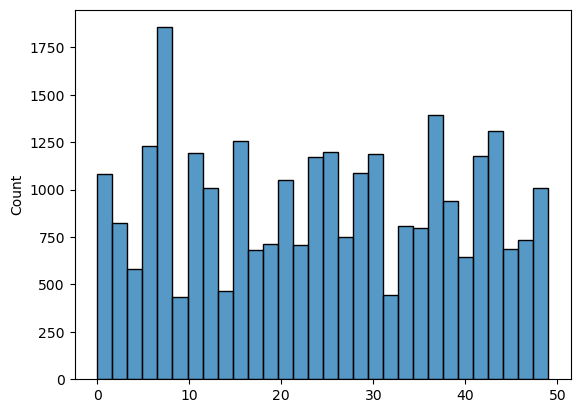

In [101]:
sns.histplot(clusters)

In [102]:
# index = faiss.IndexFlatL2(dim)
# index.add(tweet_embs_np)
# D, I = index.search(kmeans.centroids, 20)

In [103]:
# I.shape

In [104]:
# ids = I.reshape(-1)
# ids[:10]

In [105]:
train_df['cluster'] = clusters
train_df.head()

,OriginalTweet,Label,cluster
0,Think that you are safe from COVID-19 by stayi...,0,20
1,1) The way the #lockdown is implemented is a o...,1,7
2,Consumer Reports comes up with a reliable hub ...,0,17
3,Grocers struggle to keep sweet and salty snack...,0,35
4,@bloggerheads I have wiped everything in my su...,0,8


In [106]:
train_df_faiss = train_df.groupby('cluster').sample(20).reset_index(drop=True)

In [107]:
len(train_df_faiss)

1000

In [108]:
train_df_faiss.head()

,OriginalTweet,Label,cluster
0,The founder of the world's largest hedge fund ...,0,0
1,Corporate profits been falling in this sector ...,0,0
2,Even while Venezuela experienced food shortage...,1,0
3,@GoldTelegraph_ @AlexDeluce I keep seeing repo...,1,0
4,India #Gold June futures eased from highs trac...,0,0


<Axes: xlabel='cluster', ylabel='count'>

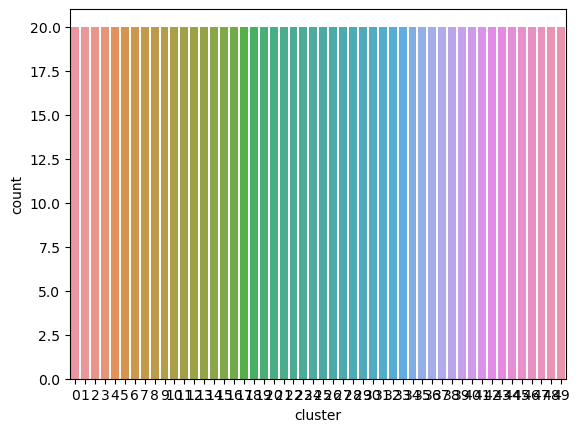

In [109]:
sns.countplot(data=train_df_faiss, x='cluster')

In [110]:
# train_df_faiss = train_df.iloc[ids].reset_index(drop=True)
# train_df_faiss.head()

In [111]:
# len(train_df_faiss)

In [112]:
train_data_faiss = TweetDataset(train_df_faiss, tokenizer, cfg['max_length'])
train_loader_faiss = DataLoader(train_data_faiss, **train_params)

In [113]:
model_faiss = TweetSentimentBERT(MODEL_PATH)
model_faiss.to(device)
num_training_steps = cfg['epochs']*len(train_loader_faiss)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_faiss.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [114]:
train(model_faiss, loss_function, train_loader_faiss, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   31    |   0.674171   |     -      |     -     |   12.33  
----------------------------------------------------------------------
   1    |    -    |   0.674171   |  0.624962  |   63.80   |   33.75  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   31    |   0.559705   |     -      |     -     |   12.32  
----------------------------------------------------------------------
   2    |    -    |   0.559705   |  0.539455  |   73.06   |   33.73  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

In [115]:
test_loss, test_accuracy = evaluate(model_faiss, loss_function, test_loader)
test_loss, test_accuracy

(0.6569437596141993, 75.15989036089539)

### Adding label to sentence before fetching embedding

In [116]:
train_df.head()

,OriginalTweet,Label,cluster
0,Think that you are safe from COVID-19 by stayi...,0,20
1,1) The way the #lockdown is implemented is a o...,1,7
2,Consumer Reports comes up with a reliable hub ...,0,17
3,Grocers struggle to keep sweet and salty snack...,0,35
4,@bloggerheads I have wiped everything in my su...,0,8


In [124]:
def add_label_to_tweets(df, tweets):
    processed_tweets = []
    for i, tweet in notebook.tqdm(enumerate(tweets)):
        if df.iloc[i].Label == 0:
            tweet = tweet + '. POSITIVE'
        else:
            tweet = tweet + '. NEGATIVE'
        processed_tweets.append(tweet)
    return processed_tweets

In [125]:
tweets = train_df.OriginalTweet.values
tweets = add_label_to_tweets(train_df, tweets)

0it [00:00, ?it/s]

In [126]:
tweets[:5]

['Think that you are safe from COVID-19 by staying home and just ordering everything you need on Amazon? \r\r\n\r\r\nThink again. \r\r\n\r\r\nYou are probably more safe just shopping at your local grocery store with a face mask and latex gloves on.\r\r\n\r\r\nhttps://t.co/XT6x25JCG9. POSITIVE',
 '1) The way the #lockdown is implemented is a offending common sense.\r\r\nWith #supermarket, #hospital and #work being the redistribution centre of #coronavirus, we stand no chance to #FlattenTheCurve in good time or at all.. NEGATIVE',
 'Consumer Reports comes up with a reliable hub Coronavirus  information and itÂ\x92s free. https://t.co/HKSdfJKwBu. POSITIVE',
 'Grocers struggle to keep sweet and salty snacks in stock as consumers look for comfort in cookies and chips amid growing coronavirus fears. POSITIVE',
 '@bloggerheads I have wiped everything in my supermarket delivery with a soapy cloth since #Covid_19  - so glad I do now hearing that!\r\r\nPickers &amp; shelf stackers could be infec

In [127]:
tweet_embeddings = get_embeddings(tweets)

Batches:   0%|          | 0/889 [00:00<?, ?it/s]

In [128]:
tweet_embs_np = tweet_embeddings.detach().cpu().numpy()
tweet_embs_np.shape

(28427, 384)

In [129]:
ncentroids = 50
niter = 20
verbose = True
kmeans = faiss.Kmeans(dim, ncentroids, niter=niter, verbose=verbose)
kmeans.train(tweet_embs_np)

Sampling a subset of 12800 / 28427 for training
Clustering 12800 points in 384D to 50 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s


7019.65771484375

In [130]:
# I contains nearest centroid to each embedding
_, clusters = kmeans.index.search(tweet_embs_np, 1)
# flattening the result
clusters = clusters.reshape(-1)
clusters.shape

(28427,)

<Axes: ylabel='Count'>

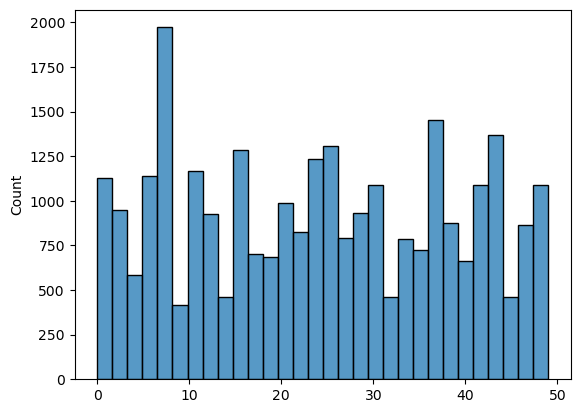

In [131]:
sns.histplot(clusters)

In [132]:
train_df['cluster'] = clusters
train_df.head()

,OriginalTweet,Label,cluster
0,Think that you are safe from COVID-19 by stayi...,0,20
1,1) The way the #lockdown is implemented is a o...,1,7
2,Consumer Reports comes up with a reliable hub ...,0,17
3,Grocers struggle to keep sweet and salty snack...,0,35
4,@bloggerheads I have wiped everything in my su...,0,2


In [133]:
train_df_faiss_2 = train_df.groupby('cluster').sample(20).reset_index(drop=True)

In [134]:
len(train_df_faiss_2)

1000

In [135]:
train_data_faiss_2 = TweetDataset(train_df_faiss_2, tokenizer, cfg['max_length'])
train_loader_faiss_2 = DataLoader(train_data_faiss_2, **train_params)

In [136]:
model_faiss_2 = TweetSentimentBERT(MODEL_PATH)
model_faiss_2.to(device)
num_training_steps = cfg['epochs']*len(train_loader_faiss_2)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_faiss_2.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [137]:
train(model_faiss_2, loss_function, train_loader_faiss_2, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   31    |   0.665110   |     -      |     -     |   12.12  
----------------------------------------------------------------------
   1    |    -    |   0.665110   |  0.594556  |   68.92   |   33.14  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   31    |   0.545539   |     -      |     -     |   12.15  
----------------------------------------------------------------------
   2    |    -    |   0.545539   |  0.522651  |   73.41   |   33.16  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

In [138]:
test_loss, test_accuracy = evaluate(model_faiss_2, loss_function, test_loader)
test_loss, test_accuracy

(0.6574959985387685, 75.61386477843764)